# Prediction

In [221]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import json
import pickle
from PIL import Image
import cv2
import keyboard
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import clear_output
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns

In [224]:
def loadModel(modArchitecture, modWeights):
    with open(modArchitecture, 'r') as file:
        model = keras.models.model_from_json(file.read())
    
    model.load_weights(modWeights)
    
    return model

def predictFromIm(mod, img, dataset, labels):
    if type(img) == str:
        orig = cv2.imread(img)
    else:
        orig = img
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    if dataset == 'leapGestRecog':
        gray = np.array(Image.fromarray(gray).resize((128, 128))).reshape(1, 128, 128, 1)
        predProb = mod.predict(gray)
        pred = predProb.argmax()
        label = labels[pred]
        return label, str({label: predProb[0][i] for i, label in enumerate(labels)})
    
    thresh, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    resBinary = np.array(Image.fromarray(binary).resize((128, 128))).reshape(1, 128, 128, 1)
    predProb = mod.predict(resBinary)
    pred = predProb.argmax()
    label = labels[pred]
    
    
    return label, str({label: predProb[0][i] for i, label in enumerate(labels)}), Image.fromarray(binary), Image.open('/Users/amanchopra/Documents/School/College/Spring 2021/CS 390 (NIP)/Final Project/Data/emojis/{}.png'.format(label))

def realTimePrediction(data, mod, dataset, labels):
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read() 
        im = Image.fromarray(frame).convert('L').resize((128, 128))
        display(im)
        im = np.array(im).reshape(1, 128, 128, 1)
        if dataset == 'leapGestRecog':
            label, probs = predictFromIm(mod, frame, dataset, labels)
            print('Label: {}'.format(label))
            print('Probabilities: {}'.format(probs))
            print()
        elif dataset == 'handGestures':
            label, probs, binImage, emoji = predictFromIm(mod, frame, dataset, labels)
            display(binImage)
            display(emoji.resize((128, 128)))
            print('Probabilities: {}'.format(probs))
            print()
        if input() == 'q':
            break

def getModAcc(mod, data):
    xTest = data[1]
    yTest = data[3]

    predProbs = mod.predict(xTest)
    predLabels = [pred.argmax() for pred in predProbs]
    predTrue = [y.argmax() for y in yTest]
    
    return np.sum(np.array(predLabels) == np.array(predTrue))/len(predTrue)

def getConfusionMat(mod, data):
    xTest = data[1]
    yTest = data[3]

    predProbs = mod.predict(xTest)
    predLabels = [pred.argmax() for pred in predProbs]
    predTrue = [y.argmax() for y in yTest]
    return confusion_matrix(predTrue, predLabels)


## Emoji Hand Gesture Dataset

In [222]:
dataset = 'handGestures'
data = pickle.load(open('data_{}.pkl'.format(dataset), 'rb'))
labels = data[4].classes_

mod = loadModel('mod_{}.json'.format(dataset), 'mod_{}.h5'.format(dataset))
mod.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 28, 28, 32)      

In [217]:
print('Test Accuracy: {}'.format(getModAcc(mod, data)))

Test Accuracy: 0.9397406559877955


Text(0.5, 1.0, 'Confusion Matrix')

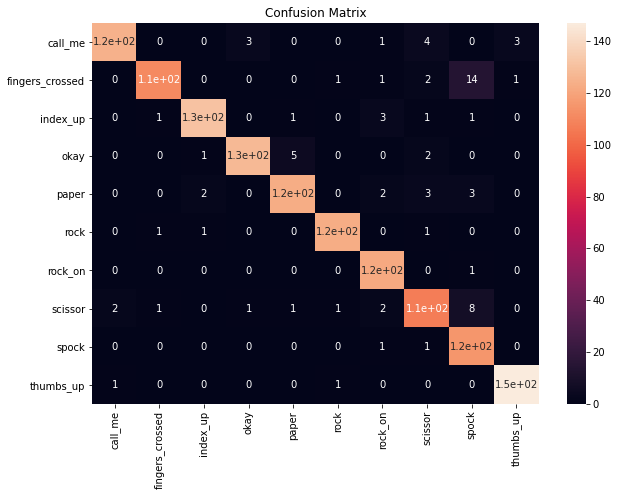

In [227]:
df_cm = pd.DataFrame(getConfusionMat(mod, data), index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')

**Real Time Streaming**

In [199]:
preds = [predictFromIm(mod, '/Users/amanchopra/Documents/School/College/Spring 2021/CS 390 (NIP)/Final Project/Data/test_handGestures/{}.jpg'.format(emoji), dataset, labels) for emoji in labels]

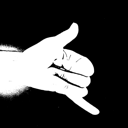

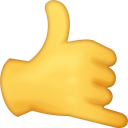

Probabilities: {'call_me': 0.990738, 'fingers_crossed': 8.37431e-11, 'index_up': 6.911703e-09, 'okay': 0.0092277825, 'paper': 1.1495659e-05, 'rock': 1.5751937e-05, 'rock_on': 2.483659e-07, 'scissor': 4.1317193e-07, 'spock': 3.933251e-10, 'thumbs_up': 6.3674543e-06}



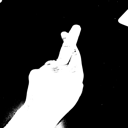

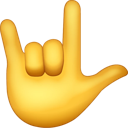

Probabilities: {'call_me': 7.0592776e-08, 'fingers_crossed': 0.0044004326, 'index_up': 7.067426e-05, 'okay': 3.9998074e-05, 'paper': 1.6114298e-05, 'rock': 0.00063243066, 'rock_on': 0.9943845, 'scissor': 0.0004363199, 'spock': 1.7048942e-05, 'thumbs_up': 2.3882128e-06}



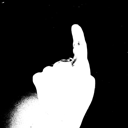

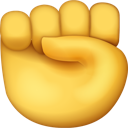

Probabilities: {'call_me': 2.4457733e-05, 'fingers_crossed': 0.44440737, 'index_up': 0.00055906386, 'okay': 0.0107993735, 'paper': 0.00012340304, 'rock': 0.5082324, 'rock_on': 0.014458741, 'scissor': 0.004966955, 'spock': 0.009042858, 'thumbs_up': 0.007385385}



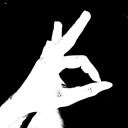

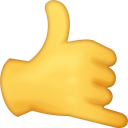

Probabilities: {'call_me': 0.6444904, 'fingers_crossed': 3.9206123e-09, 'index_up': 0.28203565, 'okay': 0.07251783, 'paper': 0.0009518539, 'rock': 1.8739572e-09, 'rock_on': 1.1381594e-07, 'scissor': 7.2525455e-07, 'spock': 2.15431e-12, 'thumbs_up': 3.379423e-06}



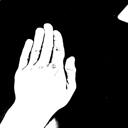

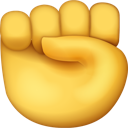

Probabilities: {'call_me': 1.1070128e-09, 'fingers_crossed': 2.1397162e-09, 'index_up': 2.8094565e-13, 'okay': 4.566251e-15, 'paper': 1.215368e-13, 'rock': 0.99994326, 'rock_on': 9.7383546e-11, 'scissor': 3.9374922e-13, 'spock': 5.6691144e-05, 'thumbs_up': 3.5443466e-09}



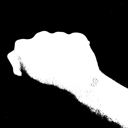

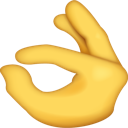

Probabilities: {'call_me': 0.014844735, 'fingers_crossed': 1.3256109e-13, 'index_up': 5.7602434e-10, 'okay': 0.9756235, 'paper': 5.0405297e-10, 'rock': 0.009531731, 'rock_on': 1.6210028e-10, 'scissor': 2.0908729e-08, 'spock': 1.051906e-09, 'thumbs_up': 1.825335e-11}



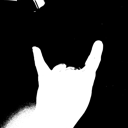

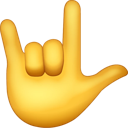

Probabilities: {'call_me': 4.1755998e-11, 'fingers_crossed': 1.4820732e-07, 'index_up': 2.759757e-10, 'okay': 3.7826705e-08, 'paper': 1.1541127e-06, 'rock': 5.15342e-09, 'rock_on': 0.9999976, 'scissor': 1.4094511e-11, 'spock': 6.7384184e-07, 'thumbs_up': 2.2419609e-07}



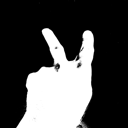

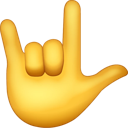

Probabilities: {'call_me': 9.557173e-10, 'fingers_crossed': 0.0005562099, 'index_up': 3.651162e-11, 'okay': 0.016655406, 'paper': 0.012202277, 'rock': 0.052948825, 'rock_on': 0.678844, 'scissor': 0.23837188, 'spock': 0.00042143563, 'thumbs_up': 1.1028242e-09}



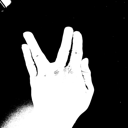

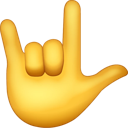

Probabilities: {'call_me': 8.245239e-16, 'fingers_crossed': 8.727542e-10, 'index_up': 1.6050025e-12, 'okay': 1.3183529e-10, 'paper': 1.1097998e-11, 'rock': 0.0044400515, 'rock_on': 0.99534756, 'scissor': 2.250556e-06, 'spock': 0.00021012708, 'thumbs_up': 1.3640867e-13}



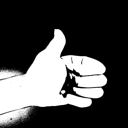

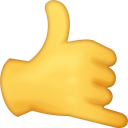

Probabilities: {'call_me': 0.99901175, 'fingers_crossed': 8.1406556e-13, 'index_up': 0.00010408763, 'okay': 0.0008735313, 'paper': 7.805508e-06, 'rock': 1.3416607e-06, 'rock_on': 4.2149155e-09, 'scissor': 1.2163715e-08, 'spock': 1.84348e-12, 'thumbs_up': 1.4462952e-06}



In [213]:
for pred in preds:
    display(pred[2].resize((128, 128)))
    display(pred[3].resize((128, 128)))
    print('Probabilities: {}'.format(pred[1]))
    print()

## Leap Hand Gesture Dataset

In [228]:
dataset = 'leapGestRecog'
data = pickle.load(open('data_{}.pkl'.format(dataset), 'rb'))
labels = data[4].classes_

mod = loadModel('mod_{}.json'.format(dataset), 'mod_{}.h5'.format(dataset))
mod.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)       

In [219]:
print('Test Accuracy: {}'.format(getModAcc(mod, data)))

Test Accuracy: 0.999


Text(0.5, 1.0, 'Confusion Matrix')

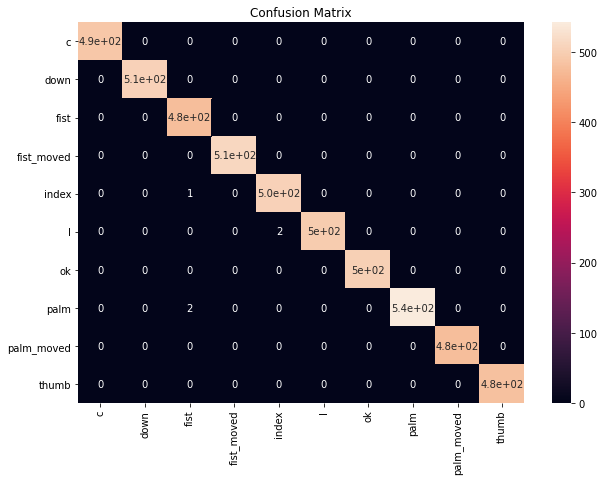

In [229]:
df_cm = pd.DataFrame(getConfusionMat(mod, data), index = labels,
                  columns = labels)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')

**Real Time Streaming**

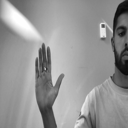

Label: palm
Probabilities: {'c': 3.6839047e-18, 'down': 1.216162e-12, 'fist': 1.7370589e-15, 'fist_moved': 3.1379552e-06, 'index': 2.012887e-12, 'l': 7.640356e-15, 'ok': 1.3023278e-15, 'palm': 0.9999969, 'palm_moved': 9.4387574e-11, 'thumb': 4.1354212e-18}




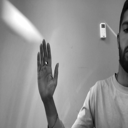

Label: palm
Probabilities: {'c': 3.6839047e-18, 'down': 1.216162e-12, 'fist': 1.7370589e-15, 'fist_moved': 3.1379552e-06, 'index': 2.012887e-12, 'l': 7.640356e-15, 'ok': 1.3023278e-15, 'palm': 0.9999969, 'palm_moved': 9.4387574e-11, 'thumb': 4.1354212e-18}




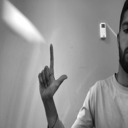

Label: l
Probabilities: {'c': 3.0674858e-18, 'down': 2.7163605e-15, 'fist': 1.158095e-16, 'fist_moved': 7.38931e-20, 'index': 1.2820204e-06, 'l': 0.9999987, 'ok': 1.2334234e-19, 'palm': 4.531207e-16, 'palm_moved': 3.2943072e-20, 'thumb': 9.443426e-21}




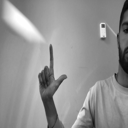

Label: l
Probabilities: {'c': 1.2816149e-27, 'down': 5.8133425e-28, 'fist': 3.0514026e-21, 'fist_moved': 5.783685e-19, 'index': 1.7140357e-19, 'l': 1.0, 'ok': 1.07766816e-13, 'palm': 1.07634116e-13, 'palm_moved': 5.8443743e-16, 'thumb': 9.211733e-15}




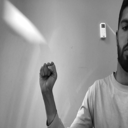

Label: fist
Probabilities: {'c': 4.1479382e-11, 'down': 9.235299e-13, 'fist': 1.0, 'fist_moved': 5.7778676e-10, 'index': 9.107661e-19, 'l': 1.7216823e-20, 'ok': 3.179139e-19, 'palm': 1.0664054e-10, 'palm_moved': 1.2264835e-15, 'thumb': 1.2645001e-14}




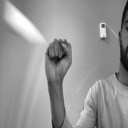

Label: fist
Probabilities: {'c': 2.8833199e-12, 'down': 2.1450628e-14, 'fist': 1.0, 'fist_moved': 1.2927229e-10, 'index': 1.847321e-20, 'l': 3.9712127e-20, 'ok': 6.9839914e-19, 'palm': 2.376508e-09, 'palm_moved': 2.1238734e-17, 'thumb': 4.122183e-13}




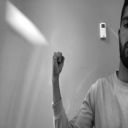

Label: fist_moved
Probabilities: {'c': 1.7377239e-11, 'down': 5.2618987e-15, 'fist': 2.4948097e-09, 'fist_moved': 1.0, 'index': 8.175852e-15, 'l': 1.3429053e-20, 'ok': 2.661524e-19, 'palm': 9.461439e-12, 'palm_moved': 3.6399028e-13, 'thumb': 8.206241e-18}




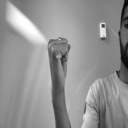

Label: fist_moved
Probabilities: {'c': 2.6137892e-21, 'down': 5.2124447e-18, 'fist': 2.7000403e-12, 'fist_moved': 1.0, 'index': 3.0878192e-21, 'l': 4.4570973e-18, 'ok': 7.6906064e-25, 'palm': 2.2248837e-13, 'palm_moved': 2.4837416e-17, 'thumb': 3.2222062e-16}




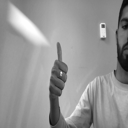

Label: thumb
Probabilities: {'c': 4.2046456e-33, 'down': 0.0, 'fist': 2.0440337e-20, 'fist_moved': 5.039493e-23, 'index': 4.903655e-23, 'l': 4.4920808e-29, 'ok': 5.0438318e-26, 'palm': 7.307759e-24, 'palm_moved': 5.956441e-38, 'thumb': 1.0}




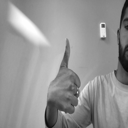

Label: thumb
Probabilities: {'c': 1.0803169e-14, 'down': 3.122994e-16, 'fist': 1.3707847e-06, 'fist_moved': 8.1203416e-19, 'index': 1.2948213e-21, 'l': 1.3490244e-19, 'ok': 1.3849255e-18, 'palm': 4.9675832e-17, 'palm_moved': 1.4958954e-28, 'thumb': 0.9999987}




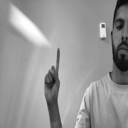

Label: index
Probabilities: {'c': 9.246284e-12, 'down': 9.71918e-15, 'fist': 1.3305527e-16, 'fist_moved': 6.1739524e-15, 'index': 1.0, 'l': 9.238175e-12, 'ok': 3.833474e-18, 'palm': 1.8059432e-16, 'palm_moved': 1.7619152e-17, 'thumb': 5.023893e-21}




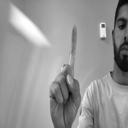

Label: index
Probabilities: {'c': 9.90298e-14, 'down': 1.8797107e-13, 'fist': 6.45018e-17, 'fist_moved': 6.3615877e-13, 'index': 1.0, 'l': 1.0314026e-12, 'ok': 1.0385342e-17, 'palm': 1.6289328e-14, 'palm_moved': 2.6111063e-15, 'thumb': 1.909161e-22}




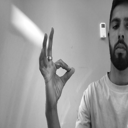

Label: ok
Probabilities: {'c': 1.09347315e-23, 'down': 8.48312e-27, 'fist': 8.30543e-29, 'fist_moved': 3.460679e-26, 'index': 2.4613813e-22, 'l': 2.2725123e-35, 'ok': 1.0, 'palm': 1.5071188e-27, 'palm_moved': 8.541708e-25, 'thumb': 1.8108549e-31}




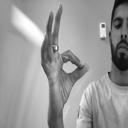

Label: ok
Probabilities: {'c': 4.247911e-13, 'down': 3.048206e-19, 'fist': 2.5411307e-08, 'fist_moved': 5.7124437e-19, 'index': 3.1158783e-18, 'l': 3.917779e-21, 'ok': 0.9999999, 'palm': 1.6278047e-11, 'palm_moved': 5.9918906e-19, 'thumb': 8.108944e-08}




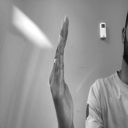

Label: palm_moved
Probabilities: {'c': 4.917433e-19, 'down': 8.773742e-17, 'fist': 1.9743005e-22, 'fist_moved': 1.6644068e-21, 'index': 2.6821627e-12, 'l': 2.66534e-22, 'ok': 1.6817654e-15, 'palm': 4.9729147e-18, 'palm_moved': 1.0, 'thumb': 4.1992363e-29}




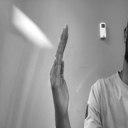

Label: palm_moved
Probabilities: {'c': 4.7358406e-10, 'down': 1.7481941e-13, 'fist': 1.101768e-15, 'fist_moved': 8.929618e-10, 'index': 5.485028e-12, 'l': 2.1084538e-18, 'ok': 5.013597e-12, 'palm': 1.13184e-14, 'palm_moved': 1.0, 'thumb': 4.1172073e-25}




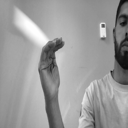

Label: c
Probabilities: {'c': 1.0, 'down': 0.0, 'fist': 0.0, 'fist_moved': 2.4662212e-30, 'index': 0.0, 'l': 0.0, 'ok': 0.0, 'palm': 0.0, 'palm_moved': 0.0, 'thumb': 0.0}




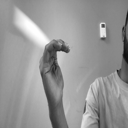

Label: c
Probabilities: {'c': 1.0, 'down': 0.0, 'fist': 0.0, 'fist_moved': 2.4662212e-30, 'index': 0.0, 'l': 0.0, 'ok': 0.0, 'palm': 0.0, 'palm_moved': 0.0, 'thumb': 0.0}




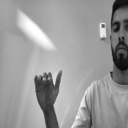

Label: down
Probabilities: {'c': 2.7545274e-35, 'down': 1.0, 'fist': 2.38467e-22, 'fist_moved': 1.2945425e-27, 'index': 3.856937e-36, 'l': 5.00867e-25, 'ok': 1.2737343e-26, 'palm': 1.1113763e-21, 'palm_moved': 1.2140938e-27, 'thumb': 2.5070667e-37}




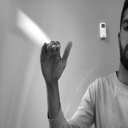

Label: down
Probabilities: {'c': 1.4633985e-35, 'down': 1.0, 'fist': 3.9470703e-24, 'fist_moved': 9.2254904e-21, 'index': 5.669401e-17, 'l': 3.73426e-17, 'ok': 1.9840005e-31, 'palm': 1.6180451e-18, 'palm_moved': 7.76464e-29, 'thumb': 9.253182e-16}

q


In [204]:
realTimePrediction(data, mod, dataset, labels)
clear_output()